In [17]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import json
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [3]:
PATH_TO_DATA = './data/'

In [4]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

In [5]:
def preprocess(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            output_list.append(content_no_html_tags)
    return output_list

In [6]:
%%time
train_raw_content = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 
                                                                  'train.json'),)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


CPU times: user 4min 29s, sys: 2.52 s, total: 4min 31s
Wall time: 4min 31s


In [7]:
%%time
test_raw_content = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 
                                                                  'test.json'),)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


CPU times: user 2min 29s, sys: 1.46 s, total: 2min 31s
Wall time: 2min 31s


In [10]:
cv = CountVectorizer(max_features=50000)

In [11]:
%%time
X_train = cv.fit_transform(train_raw_content)

CPU times: user 1min 33s, sys: 1.57 s, total: 1min 34s
Wall time: 1min 34s


In [12]:
%%time
X_test = cv.transform(test_raw_content)

CPU times: user 45.1 s, sys: 352 ms, total: 45.4 s
Wall time: 45.5 s


In [13]:
X_train.shape, X_test.shape

((62313, 50000), (34645, 50000))

In [14]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')

In [15]:
y_train = train_target['log_recommends'].values

In [16]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [18]:
ridge = Ridge(random_state=17)

In [19]:
%%time
ridge.fit(X_train_part, y_train_part)

CPU times: user 2min 28s, sys: 724 ms, total: 2min 28s
Wall time: 2min 29s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [20]:
ridge_pred = ridge.predict(X_valid)

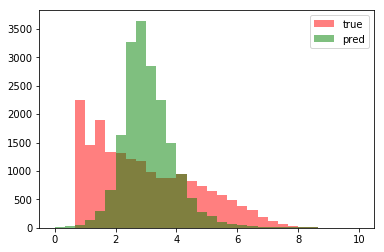

In [21]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

In [22]:
valid_mae = mean_absolute_error(y_valid, ridge_pred)
valid_mae, np.expm1(valid_mae)

(1.3060947121324362, 2.691728262156526)

In [23]:
%%time
ridge.fit(X_train, y_train);

CPU times: user 3min 31s, sys: 1 s, total: 3min 32s
Wall time: 3min 42s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [26]:
%%time
ridge_test_pred = ridge.predict(X_test)

CPU times: user 68.8 ms, sys: 40 ms, total: 109 ms
Wall time: 506 ms


In [32]:
ridge_test_pred += 3

In [28]:
def write_submission_file(prediction, filename,
    path_to_sample=os.path.join(PATH_TO_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [33]:
write_submission_file(prediction=ridge_test_pred, 
                      filename='./submission/first_ridge+3.csv')